In [1]:
import math
import cv2
import numpy as np
from time import time
import matplotlib.pyplot as plt

In [2]:
!pip install mediapipe opencv-python
!pip install opencv-python

In [3]:
import mediapipe as mp

# Initializing mediapipe pose class
mp_pose = mp.solutions.pose

# Setting up the Pose function
pose = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.8, model_complexity=2)

# Initializing mediapipe drawing class, useful for annotation
mp_drawing = mp.solutions.drawing_utils


In [6]:
def detectPose(image, pose, display=True):
    # Create a copy of the input image
    output_image = image.copy()

    # Convert the image from BGR to RGB format
    imageRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Perform the Pose Detection
    results = pose.process(imageRGB)

    # Retrieve the height and width of the input image
    height, width, _ = image.shape

    # Initialize a list to store the detected landmarks
    landmarks = []

    # Check if any landmarks are detected
    if results.pose_landmarks:
        # Draw pose landmarks on the output image
        mp_drawing.draw_landmarks(
            image=output_image,
            landmark_list=results.pose_landmarks,
            connections=mp_pose.POSE_CONNECTIONS
        )

        # Iterate over the detected landmarks
        for landmark in results.pose_landmarks.landmark:
            # Append the landmark (scaled to image size) to the list
            landmarks.append((
                int(landmark.x * width),
                int(landmark.y * height),
                landmark.z * width  # z is depth, scaled to width for consistency
            ))

        # If display is True, show the original and output images
        if display:
            plt.figure(figsize=[22, 22])

            plt.subplot(121)
            plt.imshow(image[:, :, ::-1])
            plt.title("Original Image")
            plt.axis('off')

            plt.subplot(122)
            plt.imshow(output_image[:, :, ::-1])
            plt.title("Output Image")
            plt.axis('off')

            # Also plot the pose landmarks in 3D
            mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)

    # Final return to ensure function always returns output
    return output_image, landmarks


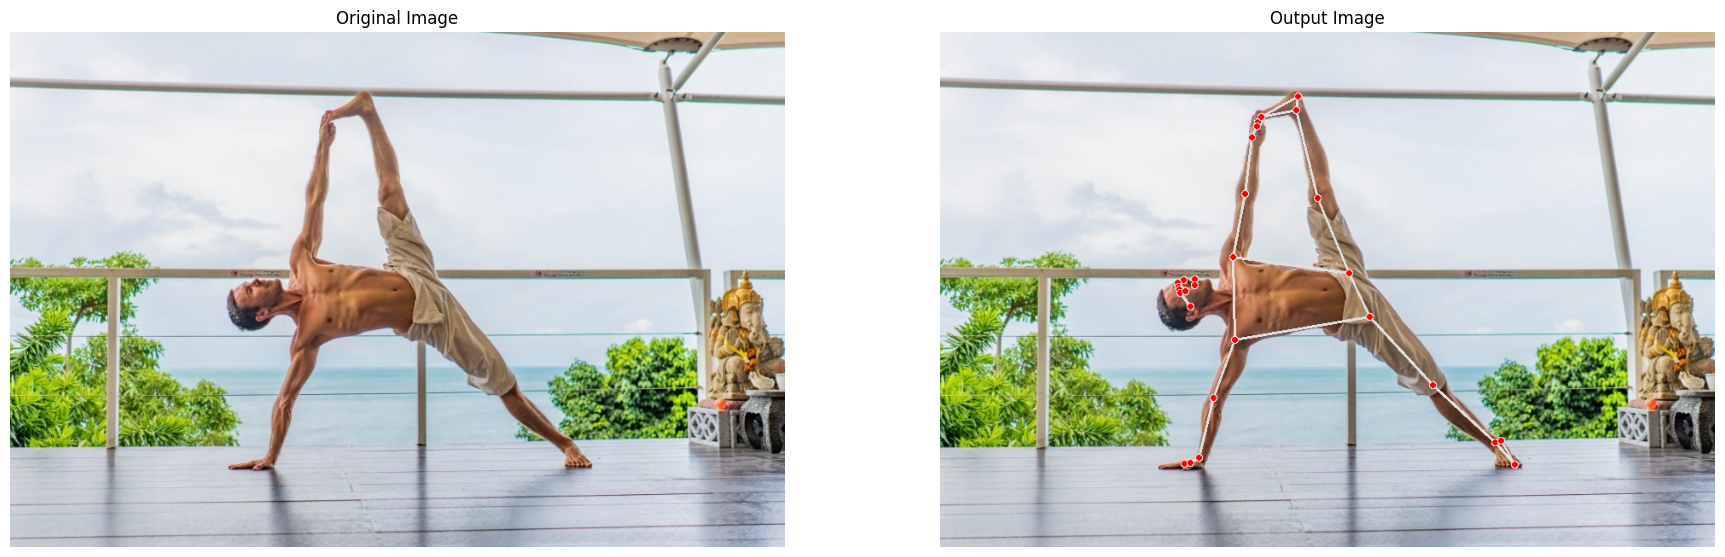

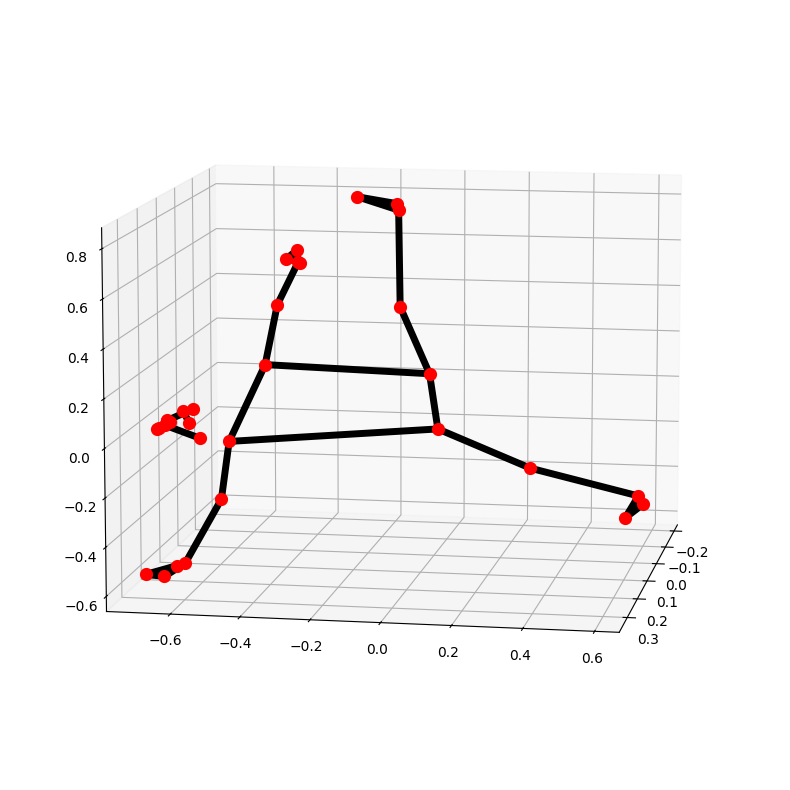

(array([[[243, 238, 237],
         [243, 238, 237],
         [243, 238, 237],
         ...,
         [147, 181, 205],
         [149, 180, 205],
         [149, 180, 205]],
 
        [[243, 238, 237],
         [243, 238, 237],
         [243, 238, 237],
         ...,
         [147, 181, 205],
         [149, 180, 205],
         [149, 180, 205]],
 
        [[243, 238, 237],
         [243, 238, 237],
         [243, 238, 237],
         ...,
         [147, 181, 204],
         [149, 181, 204],
         [149, 181, 204]],
 
        ...,
 
        [[209, 203, 196],
         [210, 204, 197],
         [212, 206, 199],
         ...,
         [223, 211, 205],
         [225, 213, 207],
         [225, 213, 207]],
 
        [[209, 203, 196],
         [210, 204, 197],
         [212, 206, 199],
         ...,
         [225, 213, 207],
         [227, 215, 209],
         [227, 215, 209]],
 
        [[209, 203, 198],
         [211, 205, 200],
         [212, 206, 201],
         ...,
         [226, 214, 208],
  

In [7]:
image = cv2.imread(r"C:\Users\supri\OneDrive\Desktop\exercise 2.jpg")
detectPose(image,pose,display =True)

In [8]:
import cv2
import time
import mediapipe as mp
import math

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, model_complexity=1)

# Open webcam
video = cv2.VideoCapture(0)
if not video.isOpened():
    print("Error: Could not open video source.")
    exit()

cv2.namedWindow("Pose Detection", cv2.WINDOW_NORMAL)
video.set(3, 1280)
video.set(4, 960)

time1 = 0

# ----------- Utility Angle Function ------------
def calculateAngle(a, b, c):
    x1, y1 = a.x, a.y
    x2, y2 = b.x, b.y
    x3, y3 = c.x, c.y
    angle = math.degrees(math.atan2(y3 - y2, x3 - x2) -
                         math.atan2(y1 - y2, x1 - x2))
    return angle + 360 if angle < 0 else angle
# Global counters and stages
squat_count = 0
squat_stage = None

pushup_count = 0
pushup_stage = None

situp_count = 0
situp_stage = None

lateral_raise_count = 0
lateral_raise_stage = None

# ----------- Squat Detection ------------
def detectSquat(landmarks):
    global squat_count, squat_stage

    label = None
    feedback = []

    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    left_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
    right_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value])

    # Check if full squat position
    if (80 < left_knee_angle < 120 and 80 < right_knee_angle < 120 and
        70 < left_hip_angle < 110 and 70 < right_hip_angle < 110):
        label = "Squat"
        if squat_stage == "down":
            squat_stage = "up"
            squat_count += 1

    # Check if bending down (pre-squat)
    elif 60 < left_knee_angle < 150 or 60 < right_knee_angle < 150:
        label = "Almost Squat"
        squat_stage = "down"
        if not (80 < left_knee_angle < 120): feedback.append("Bend left knee more")
        if not (80 < right_knee_angle < 120): feedback.append("Bend right knee more")
        if not (70 < left_hip_angle < 110): feedback.append("Lower left hip")
        if not (70 < right_hip_angle < 110): feedback.append("Lower right hip")

    return label, feedback

# ----------- Side Plank Detection ------------
def detectSidePlank(landmarks):
    label = None
    feedback = []

    left_shoulder = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value]
    left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value]
    left_ankle = landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value]

    right_shoulder = landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value]
    right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value]
    right_ankle = landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value]

    left_body_angle = calculateAngle(left_shoulder, left_hip, left_ankle)
    right_body_angle = calculateAngle(right_shoulder, right_hip, right_ankle)

    # Check if one side is straight and the other is elevated
    if 150 < left_body_angle < 210:
        label = "Left Side Plank"
    elif 150 < right_body_angle < 210:
        label = "Right Side Plank"
    elif 120 < left_body_angle < 150 or 120 < right_body_angle < 150:
        label = "Almost Side Plank"
        if not (150 < left_body_angle < 210):
            feedback.append("Straighten left body line")
        if not (150 < right_body_angle < 210):
            feedback.append("Straighten right body line")

    return label, feedback

def detectDumbbellLateralRaise(landmarks):
    global lateral_raise_count, lateral_raise_stage

    label = None
    feedback = []

    left_shoulder_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value]
    )
    right_shoulder_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value]
    )

    left_elbow_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
        landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value]
    )
    right_elbow_angle = calculateAngle(
        landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
        landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value]
    )

    left_arm_level = abs(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value].y -
                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y) < 0.05
    right_arm_level = abs(landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value].y -
                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y) < 0.05

    # Full raise position
    if (
        70 < left_shoulder_angle < 110 and 70 < right_shoulder_angle < 110 and
        150 < left_elbow_angle < 180 and 150 < right_elbow_angle < 180 and
        left_arm_level and right_arm_level
    ):
        label = "Dumbbell Lateral Raise"
        if lateral_raise_stage == "down":
            lateral_raise_stage = "up"
            lateral_raise_count += 1

    # Going down
    elif (
        40 < left_shoulder_angle < 130 or 40 < right_shoulder_angle < 130
    ):
        label = "Almost Lateral Raise"
        lateral_raise_stage = "down"
        if not left_arm_level: feedback.append("Raise left arm fully")
        if not right_arm_level: feedback.append("Raise right arm fully")
        if not (150 < left_elbow_angle < 180): feedback.append("Straighten left arm")
        if not (150 < right_elbow_angle < 180): feedback.append("Straighten right arm")

    return label, feedback



# ----------- Push-Up Detection ------------
def detectPushUp(landmarks):
    global pushup_count, pushup_stage

    label = None
    feedback = []

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    left_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value],
                                     landmarks[mp_pose.PoseLandmark.LEFT_ANKLE.value])
    right_knee_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_KNEE.value],
                                      landmarks[mp_pose.PoseLandmark.RIGHT_ANKLE.value])
    
    nose_y = landmarks[mp_pose.PoseLandmark.NOSE.value].y
    shoulder_y = landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y

    if (
        80 < left_elbow_angle < 110 and 80 < right_elbow_angle < 110 and
        160 < left_knee_angle < 200 and 160 < right_knee_angle < 200 and
        nose_y > shoulder_y
    ):
        label = "Push-up"
        if pushup_stage == "down":
            pushup_stage = "up"
            pushup_count += 1
    elif 60 < left_elbow_angle < 140 or 60 < right_elbow_angle < 140:
        label = "Almost Push-up"
        feedback.append("Go lower")
        pushup_stage = "down"

    return label, feedback


# ----------- Sit-Up Detection ------------


def detectSitUp(landmarks):
    global situp_count, situp_stage

    label = None
    feedback = []

    left_hip_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_HIP.value],
                                    landmarks[mp_pose.PoseLandmark.LEFT_KNEE.value])
    
    nose_y = landmarks[mp_pose.PoseLandmark.NOSE.value].y
    hip_y = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value].y

    if 45 < left_hip_angle < 100 and nose_y < hip_y:
        label = "Sit-up"
        if situp_stage == "down":
            situp_stage = "up"
            situp_count += 1  # Increment when coming up
    elif 100 < left_hip_angle < 130:
        label = "Almost Sit-up"
        feedback.append("Lift torso more")
        situp_stage = "down"

    return label, feedback


# ----------- T-Pose Detection ------------
def detectTPose(landmarks):
    label = None
    feedback = []

    left_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                      landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value])
    right_elbow_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value],
                                       landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value])
    left_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.LEFT_ELBOW.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value],
                                         landmarks[mp_pose.PoseLandmark.LEFT_HIP.value])
    right_shoulder_angle = calculateAngle(landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value],
                                          landmarks[mp_pose.PoseLandmark.RIGHT_ELBOW.value])

    if (
        160 < left_elbow_angle < 200 and 160 < right_elbow_angle < 200 and
        70 < left_shoulder_angle < 110 and 70 < right_shoulder_angle < 110 and
        abs(landmarks[mp_pose.PoseLandmark.LEFT_WRIST.value].y -
            landmarks[mp_pose.PoseLandmark.LEFT_SHOULDER.value].y) < 0.05 and
        abs(landmarks[mp_pose.PoseLandmark.RIGHT_WRIST.value].y -
            landmarks[mp_pose.PoseLandmark.RIGHT_SHOULDER.value].y) < 0.05
    ):
        label = "T-Pose"
    elif 140 < left_elbow_angle < 210 and 140 < right_elbow_angle < 210:
        label = "Almost T-Pose"
        feedback.append("Straighten arms and level them")
    
    return label, feedback

# ----------- Main Classifier ------------
# Add the missing detect functions to the main classifier list
def classifyPose(landmarks, output_image):
    color = (0, 0, 255)
    label = "Unknown Pose"
    feedback = []

    # List of all detect functions you have
    detect_functions = [
        detectSquat, 
        detectPushUp, 
        detectSitUp, 
        detectTPose,
        detectSidePlank,
        detectDumbbellLateralRaise,
        # Add detectLunge here if implemented
    ]

    for detect_func in detect_functions:
        label_temp, feedback_temp = detect_func(landmarks)
        if label_temp:
            label = label_temp
            feedback = feedback_temp
            color = (0, 255, 0) if "Almost" not in label else (0, 165, 255)
            break

    cv2.putText(output_image, label, (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)
    for i, f in enumerate(feedback):
        cv2.putText(output_image, f, (10, 60 + i * 25), cv2.FONT_HERSHEY_PLAIN, 2, color, 2)

    return output_image, label

def displayCounters(image):
    counter_texts = [
        f'Squats: {squat_count}',
        f'Push-ups: {pushup_count}',
        f'Sit-ups: {situp_count}',
        f'Lateral Raises: {lateral_raise_count}'
    ]

    for idx, text in enumerate(counter_texts):
        cv2.putText(image, text, (10, 100 + idx * 30), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 255), 2)
    
    return image

# ----------- Pose Detection From Frame ------------
def detectPose(image, pose_model):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose_model.process(rgb_image)
    if results.pose_landmarks:
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)
        return image, results.pose_landmarks.landmark
    else:
        return image, None

# ----------- Main Loop ------------
while video.isOpened():
    ok, frame = video.read()
    if not ok:
        break

    frame = cv2.flip(frame, 1)
    frame_height, frame_width, _ = frame.shape
    frame = cv2.resize(frame, (int((frame_width / frame_height) * 640), 640))

    frame, landmarks = detectPose(frame, pose_video)
    if landmarks:
        frame, _ = classifyPose(landmarks, frame)

    time2 = time.time()
    if (time2 - time1) > 0:
        fps = 1.0 / (time2 - time1)
        cv2.putText(frame, f'FPS: {int(fps)}', (10, 60), cv2.FONT_HERSHEY_PLAIN, 2, (255, 255, 0), 2)
    time1 = time2

    cv2.imshow('Pose Detection', frame)
    if cv2.waitKey(1) & 0xFF == 27:  # ESC
        break

video.release()
cv2.destroyAllWindows()
